# Thesis Computer Vision Feature Extracton

The goal of this thesis cosists of four tasks:
* Extracting and cleaning raw pdf image data
    * Identifying chart/graph/tables 
    * Cleaning trash images using color analysis
* The first task is to identify the faces in each image and classify the following: 
    * age
    * gender
    * race
    * emotion*
* The second task is to classify images as either containing natural or artificial backgrounds
* The final task is an oject detection model that covers a large number of images of interest

#### Begining with the data cleaning we start by trianing a classifier to distinguish between natural images and charts and graphs

In [1]:
import os, urllib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2022-06-21 22:51:28.797621: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Load the data -- assembled using a combination of a Kaggle dataset
# with a personal downloader to acquire "table" category and not_chart coming from original data

DIR_ = 'Data/chart_train/'

traindf = pd.read_csv(os.path.join(DIR_,'train.csv')).iloc()[:,1:]
traindf['code'] = traindf['type'].astype('category').cat.codes
filenames = [file for file in os.listdir(os.path.join(DIR_,'Images/Images'))]
traindf = traindf[traindf.chart.isin(filenames)].reset_index(drop=True)
print(len(traindf.type.unique()), traindf.shape)
traindf.head()

15 (6444, 3)


,chart,type,code
0,1.area-chart.png,AreaGraph,0
1,10.depicting_area_chart.jpg,AreaGraph,0
2,100.stacked-area-chart-cliffs-stacked-area-cha...,AreaGraph,0
3,101.quantity2.png,AreaGraph,0
4,103.flutter-spline-area-charts.png,AreaGraph,0


In [3]:
# Next we clean the data from tranparent images as they give issues with training
def has_transparency(img):
  if img.info.get("transparency", None) is not None:
      return True
  if img.mode == "P":
      transparent = img.info.get("transparency", -1)
      for _, index in img.getcolors():
          if index == transparent:
              return True
  elif img.mode == "RGBA":
      extrema = img.getextrema()
      if extrema[3][0] < 255:
          return True

  return False

traindf['transparency'] = traindf['chart'].map(lambda x: has_transparency(Image.open(os.path.join(DIR_,'Images/Images', x))))

traindf.groupby('transparency')['chart'].nunique()
traindf = traindf[traindf.transparency == False].reset_index(drop=True)
traindf.shape

(6016, 4)

In [4]:
# We define our model that uses VGG-19 IMAGENET to transfer learn

def createModel(Model_name, final_classes):
    vgg_model = Model_name(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

    for layer in vgg_model.layers:
        layer.trainable=False
        
    input = Input(shape=(224, 224, 3), name = 'image_input')
    output_vgg19_conv = vgg_model(input)

    x = BatchNormalization()(output_vgg19_conv)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(final_classes, activation='softmax')(x)

    model = Model(inputs=input, outputs=x)

    model.summary()

    model.compile(loss = "categorical_crossentropy",
              optimizer = optimizers.Adadelta(lr = 1.0, rho = 0.95, epsilon = 1e-08, decay = 0.0),
              metrics = ['accuracy'])
    
    return model

In [19]:
# Now we split our data into trian and validation 

from sklearn.model_selection import train_test_split

train, test = train_test_split(traindf, test_size=0.2, random_state=420)

In [36]:
# def set_up_augmentation(
#     rotation_range=0,
#     height_shift_range=0, # vertical shift
#     width_shift_range=0,
#     zoom_range=0, # zoom
#     vertical_flip=False,
#     horizontal_flip=False
# ):
#     datagen_train = ImageDataGenerator(rescale=1./255.,
#                                         rotation_range=rotation_range,
#                                         height_shift_range=height_shift_range, # vertical shift
#                                         width_shift_range=width_shift_range,
#                                         zoom_range=zoom_range, # zoom
#                                         vertical_flip=vertical_flip,
#                                         horizontal_flip=horizontal_flip
#                                     ) 
            
#     datagen_valid = ImageDataGenerator(rescale=1./255)

#     return datagen_train, datagen_valid

def set_up_augmentation(
    rotation_range=0,
    guassian_blur=0, # vertical shift
    zoom = 0,
    horizontal_flip=0
):
    import imgaug as ia
    import imgaug.augmenters as iaa

    ia.seed(1411)

    seq = iaa.Sequential([
        iaa.Fliplr(horizontal_flip), # horizontal flips
        iaa.Crop(percent=(0, zoom)), # random crops
        # iaa.LinearContrast((0.75, 1.5)),
        # Small gaussian blur with random sigma between 0 and 1.0.
        # But we only blur about 25% of all images.
        iaa.Sometimes(
            guassian_blur,
            iaa.GaussianBlur(sigma=(0, 1.0))
        ),
        # Apply affine transformations to each image.
        # Scale/zoom them, translate/move them, rotate them and shear them.
        iaa.Sometimes(
        0.30, 
        iaa.Affine(rotate=(-rotation_range, rotation_range))
        )
    ], random_order=True) # apply augmenters in random order


    datagen_train = ImageDataGenerator(rescale=1./255.,
        preprocessing_function=seq.augment_image
    )

    datagen_valid = ImageDataGenerator(rescale=1./255)

    return datagen_train, datagen_valid

In [10]:
def initialize_model(Model_name, datagen_train,datagen_valid, final_classes, data):
    model = createModel(Model_name, final_classes)

    train_generator = datagen_train.flow_from_dataframe(dataframe=data,
                                            directory=os.path.join(DIR_,'Images/Images'),
                                            x_col="chart",
                                            y_col="type",
                                            batch_size=32,
                                            seed=42,
                                            color_mode="rgb",
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(224, 224)
                                            , validate_filenames=False
                                            );

    valid_generator=datagen_valid.flow_from_dataframe(dataframe=test,
                                            directory=os.path.join(DIR_,'Images/Images'),
                                            x_col="chart",
                                            y_col="type",
                                            batch_size=32,
                                            seed=42,
                                            color_mode="rgb",
                                            shuffle=False,
                                            class_mode="categorical",
                                            target_size=(224, 224)
                                            , validate_filenames=False
                                            );

    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size


    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

    return model, train_generator, valid_generator, STEP_SIZE_TRAIN, STEP_SIZE_VALID, es

In [7]:
# Before we train the model we define a helper function to illustrate results
def printHistory(history, filename):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle('VGG-19')
    
    
    ax1.set_title('Accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'val'], loc='upper left')
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    
    ax2.set_title('Loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'val'], loc='upper left')
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])

    plt.savefig(filename)

    plt.show()

##### Hyperparameter experimentation

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 512)         2048      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 512)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 4096)              3355

/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
150/150 [==============================] - 30s 193ms/step - loss: 1.5043 - accuracy: 0.5736 - val_loss: 0.5716 - val_accuracy: 0.8226
Epoch 2/30
150/150 [==============================] - 28s 189ms/step - loss: 0.5101 - accuracy: 0.8352 - val_loss: 0.4318 - val_accuracy: 0.8514
Epoch 3/30
150/150 [==============================] - 29s 194ms/step - loss: 0.3724 - accuracy: 0.8840 - val_loss: 0.4073 - val_accuracy: 0.8733
Epoch 4/30
150/150 [==============================] - 29s 194ms/step - loss: 0.2438 - accuracy: 0.9177 - val_loss: 0.3940 - val_accuracy: 0.8801
Epoch 5/30
150/150 [==============================] - 29s 190ms/step - loss: 0.1788 - accuracy: 0.9409 - val_loss: 0.4297 - val_accuracy: 0.8775
Epoch 6/30
150/150 [==============================] - 29s 191ms/step - loss: 0.1414 - accuracy: 0.9505 - val_loss: 0.4020 - val_accuracy: 0.8860
Epoch 7/30
150/150 [==============================] - 28s 188ms/step - loss: 0.0991 - accuracy: 0.9713 - val_loss: 0.4886 - val_ac

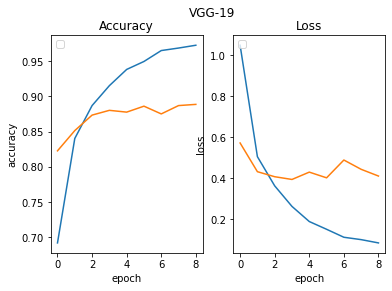

In [29]:
#Trains the model on data generated batch-by-batch by a Python generator
datagen_train, datagen_valid = set_up_augmentation()

model, train_generator, valid_generator\
    , STEP_SIZE_TRAIN, STEP_SIZE_VALID, es = \
    initialize_model(applications.VGG19, datagen_train, datagen_valid)

## Fozen [:-5] best accuracy 88%
## Currently training fully frozen -result = similar results faster train
history = model.fit_generator(generator=train_generator,\
                    validation_data = valid_generator, \
                    steps_per_epoch=STEP_SIZE_TRAIN, \
                    validation_steps=STEP_SIZE_VALID, \
                    epochs=30, \
                    verbose=1, \
                    callbacks=[es])

printHistory(history, 'output/no_aug.jpg')

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
batch_normalization_20 (Batc (None, 7, 7, 2048)        8192      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 2048)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 4, 4, 2048)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 4096)              1342

/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
150/150 [==============================] - 31s 193ms/step - loss: 2.3180 - accuracy: 0.3855 - val_loss: 1.4685 - val_accuracy: 0.5397
Epoch 2/50
150/150 [==============================] - 28s 183ms/step - loss: 1.5706 - accuracy: 0.5420 - val_loss: 1.2344 - val_accuracy: 0.6149
Epoch 3/50
150/150 [==============================] - 28s 187ms/step - loss: 1.3608 - accuracy: 0.5888 - val_loss: 1.0964 - val_accuracy: 0.6706
Epoch 4/50
150/150 [==============================] - 27s 183ms/step - loss: 1.2509 - accuracy: 0.6186 - val_loss: 1.0177 - val_accuracy: 0.6841
Epoch 5/50
150/150 [==============================] - 28s 187ms/step - loss: 1.1578 - accuracy: 0.6498 - val_loss: 1.1471 - val_accuracy: 0.6410
Epoch 6/50
150/150 [==============================] - 28s 189ms/step - loss: 1.0729 - accuracy: 0.6757 - val_loss: 1.0968 - val_accuracy: 0.6639
Epoch 7/50
150/150 [==============================] - 29s 191ms/step - loss: 1.0267 - accuracy: 0.6786 - val_loss: 1.0710 - val_ac

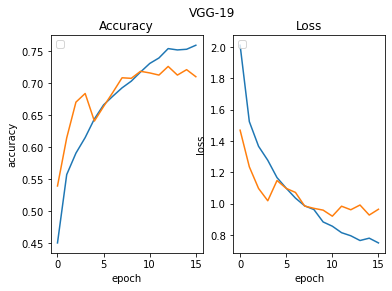

In [34]:
#Experimenting with ResNet50
datagen_train, datagen_valid = set_up_augmentation()

model, train_generator, valid_generator\
    , STEP_SIZE_TRAIN, STEP_SIZE_VALID, es = \
    initialize_model(applications.ResNet50, datagen_train, datagen_valid)

history = model.fit_generator(generator=train_generator,\
                    validation_data = valid_generator, \
                    steps_per_epoch=STEP_SIZE_TRAIN, \
                    validation_steps=STEP_SIZE_VALID, \
                    epochs=50, \
                    verbose=1, \
                    callbacks=[es])

printHistory(history, 'output/no_aug_Res.jpg')

219062272/219055592 [==============================] - 3s 0us/step
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
batch_normalization_227 (Bat (None, 5, 5, 1536)        6144      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 3, 3, 1536)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 3, 3, 1536)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 13824)             0         
__________________________________________________________

/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
150/150 [==============================] - 147s 574ms/step - loss: 1.5463 - accuracy: 0.5703 - val_loss: 0.6581 - val_accuracy: 0.8091
Epoch 2/50
150/150 [==============================] - 29s 189ms/step - loss: 0.5780 - accuracy: 0.8294 - val_loss: 0.4648 - val_accuracy: 0.8573
Epoch 3/50
150/150 [==============================] - 28s 189ms/step - loss: 0.4600 - accuracy: 0.8584 - val_loss: 0.4920 - val_accuracy: 0.8497
Epoch 4/50
150/150 [==============================] - 28s 188ms/step - loss: 0.3144 - accuracy: 0.9006 - val_loss: 0.4257 - val_accuracy: 0.8682
Epoch 5/50
150/150 [==============================] - 28s 187ms/step - loss: 0.2624 - accuracy: 0.9110 - val_loss: 0.4233 - val_accuracy: 0.8725
Epoch 6/50
150/150 [==============================] - 28s 189ms/step - loss: 0.1888 - accuracy: 0.9409 - val_loss: 0.4294 - val_accuracy: 0.8708
Epoch 7/50
150/150 [==============================] - 28s 187ms/step - loss: 0.1517 - accuracy: 0.9510 - val_loss: 0.4378 - val_a

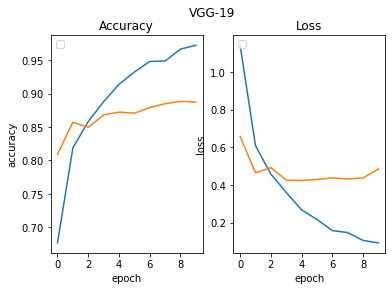

In [35]:
#Experimenting with Inception
datagen_train, datagen_valid = set_up_augmentation()

model, train_generator, valid_generator\
    , STEP_SIZE_TRAIN, STEP_SIZE_VALID, es = \
    initialize_model(applications.InceptionResNetV2, datagen_train, datagen_valid)

history = model.fit_generator(generator=train_generator,\
                    validation_data = valid_generator, \
                    steps_per_epoch=STEP_SIZE_TRAIN, \
                    validation_steps=STEP_SIZE_VALID, \
                    epochs=50, \
                    verbose=1, \
                    callbacks=[es])

printHistory(history, 'output/no_aug_INC.jpg')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
batch_normalization_12 (Batc (None, 7, 7, 512)         2048      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 512)         0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 4096)              3355

/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
150/150 [==============================] - 65s 430ms/step - loss: 1.7937 - accuracy: 0.4948 - val_loss: 0.7199 - val_accuracy: 0.7627
Epoch 2/30
150/150 [==============================] - 65s 433ms/step - loss: 0.9448 - accuracy: 0.7158 - val_loss: 0.5881 - val_accuracy: 0.8125
Epoch 3/30
150/150 [==============================] - 65s 432ms/step - loss: 0.8380 - accuracy: 0.7453 - val_loss: 0.5063 - val_accuracy: 0.8497
Epoch 4/30
150/150 [==============================] - 65s 431ms/step - loss: 0.7562 - accuracy: 0.7745 - val_loss: 0.5201 - val_accuracy: 0.8530
Epoch 5/30
150/150 [==============================] - 64s 429ms/step - loss: 0.7012 - accuracy: 0.7823 - val_loss: 0.5077 - val_accuracy: 0.8412
Epoch 6/30
150/150 [==============================] - 64s 429ms/step - loss: 0.6291 - accuracy: 0.8100 - val_loss: 0.4595 - val_accuracy: 0.8649
Epoch 7/30
150/150 [==============================] - 65s 432ms/step - loss: 0.6602 - accuracy: 0.8062 - val_loss: 0.4525 - val_ac

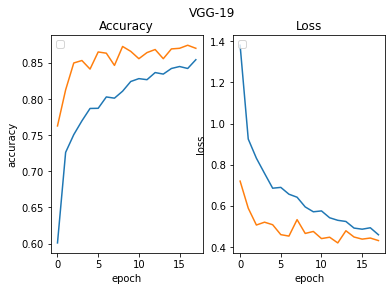

In [32]:
#Trains the model on data generated batch-by-batch by a Python generator
datagen_train, datagen_valid = set_up_augmentation(
    rotation_range=25,
    height_shift_range=0.2, # vertical shift
    width_shift_range=.2,
    zoom_range=0.1, # zoom
    vertical_flip=True,
    horizontal_flip=True
)

model, train_generator, valid_generator\
    , STEP_SIZE_TRAIN, STEP_SIZE_VALID, es = \
    initialize_model(applications.VGG19, datagen_train, datagen_valid)

## Adding augmentation -- full augmentatio set reduced overfitting but lowered over all scores
history = model.fit_generator(generator=train_generator,\
                    validation_data = valid_generator, \
                    steps_per_epoch=STEP_SIZE_TRAIN, \
                    validation_steps=STEP_SIZE_VALID, \
                    epochs=30, \
                    verbose=1, \
                    callbacks=[es])

printHistory(history, 'output/no_aug.jpg')

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
batch_normalization_231 (Bat (None, 7, 7, 512)         2048      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 512)         0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 4096)              3355

/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
150/150 [==============================] - 63s 415ms/step - loss: 1.6023 - accuracy: 0.5541 - val_loss: 0.6195 - val_accuracy: 0.8159
Epoch 2/30
150/150 [==============================] - 62s 416ms/step - loss: 0.7825 - accuracy: 0.7680 - val_loss: 0.5663 - val_accuracy: 0.8133
Epoch 3/30
150/150 [==============================] - 63s 420ms/step - loss: 0.6376 - accuracy: 0.8020 - val_loss: 0.4313 - val_accuracy: 0.8632
Epoch 4/30
150/150 [==============================] - 62s 416ms/step - loss: 0.5285 - accuracy: 0.8306 - val_loss: 0.4357 - val_accuracy: 0.8632
Epoch 5/30
150/150 [==============================] - 63s 418ms/step - loss: 0.5525 - accuracy: 0.8302 - val_loss: 0.4894 - val_accuracy: 0.8581
Epoch 6/30
150/150 [==============================] - 62s 416ms/step - loss: 0.4898 - accuracy: 0.8468 - val_loss: 0.4559 - val_accuracy: 0.8666
Epoch 7/30
150/150 [==============================] - 63s 418ms/step - loss: 0.4286 - accuracy: 0.8596 - val_loss: 0.4253 - val_ac

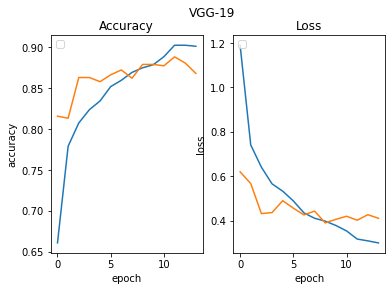

In [36]:
#Trains the model on data generated batch-by-batch by a Python generator
datagen_train, datagen_valid = set_up_augmentation(
    rotation_range=10,
    # height_shift_range=0.2, # vertical shift
    # width_shift_range=.2,
    zoom_range=0.1, # zoom
    vertical_flip=True,
    horizontal_flip=True
)

model, train_generator, valid_generator\
    , STEP_SIZE_TRAIN, STEP_SIZE_VALID, es = \
    initialize_model(applications.VGG19, datagen_train, datagen_valid)

## testing lower augmentation levels
history = model.fit_generator(generator=train_generator,\
                    validation_data = valid_generator, \
                    steps_per_epoch=STEP_SIZE_TRAIN, \
                    validation_steps=STEP_SIZE_VALID, \
                    epochs=30, \
                    verbose=1, \
                    callbacks=[es])

printHistory(history, 'output/no_aug.jpg')

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
batch_normalization_852 (Bat (None, 5, 5, 1536)        6144      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 3, 3, 1536)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 3, 3, 1536)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 13824)             0         
_________________________________________________________________
dense_40 (Dense)             (None, 4096)              566

/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
150/150 [==============================] - 74s 439ms/step - loss: 1.6914 - accuracy: 0.5374 - val_loss: 0.7645 - val_accuracy: 0.7660
Epoch 2/40
150/150 [==============================] - 63s 422ms/step - loss: 0.9287 - accuracy: 0.7254 - val_loss: 0.6481 - val_accuracy: 0.8032
Epoch 3/40
150/150 [==============================] - 63s 422ms/step - loss: 0.7245 - accuracy: 0.7754 - val_loss: 0.6253 - val_accuracy: 0.8032
Epoch 4/40
150/150 [==============================] - 62s 415ms/step - loss: 0.7270 - accuracy: 0.7692 - val_loss: 0.5673 - val_accuracy: 0.8235
Epoch 5/40
150/150 [==============================] - 63s 423ms/step - loss: 0.6389 - accuracy: 0.7981 - val_loss: 0.5533 - val_accuracy: 0.8209
Epoch 6/40
150/150 [==============================] - 63s 420ms/step - loss: 0.6353 - accuracy: 0.8022 - val_loss: 0.5378 - val_accuracy: 0.8412
Epoch 7/40
150/150 [==============================] - 63s 420ms/step - loss: 0.5296 - accuracy: 0.8280 - val_loss: 0.5412 - val_ac

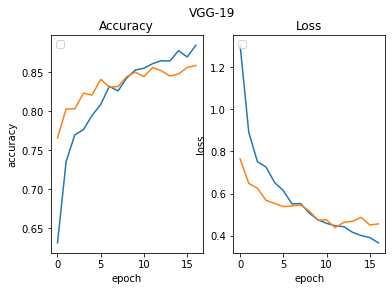

In [39]:
#Trains the model on data generated batch-by-batch by a Python generator
datagen_train, datagen_valid = set_up_augmentation(
    rotation_range=90,
    # height_shift_range=0.2, # vertical shift
    # width_shift_range=.2,
    # zoom_range=0.2, # zoom
    # vertical_flip=True,
    horizontal_flip=True
)

model, train_generator, valid_generator\
    , STEP_SIZE_TRAIN, STEP_SIZE_VALID, es = \
    initialize_model(applications.InceptionResNetV2, datagen_train, datagen_valid)

## testing lower augmentation levels
history = model.fit_generator(generator=train_generator,\
                    validation_data = valid_generator, \
                    steps_per_epoch=STEP_SIZE_TRAIN, \
                    validation_steps=STEP_SIZE_VALID, \
                    epochs=40, \
                    verbose=1, \
                    callbacks=[es])

printHistory(history, 'output/aug_INC.jpg')

##### Final model training and evaluation

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
batch_normalization_16 (Batc (None, 7, 7, 512)         2048      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 512)         0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 4096)              3355

/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
150/150 [==============================] - 42s 270ms/step - loss: 1.7769 - accuracy: 0.4993 - val_loss: 0.7993 - val_accuracy: 0.7559
Epoch 2/50
150/150 [==============================] - 40s 266ms/step - loss: 0.8830 - accuracy: 0.7321 - val_loss: 0.5919 - val_accuracy: 0.8193
Epoch 3/50
150/150 [==============================] - 38s 255ms/step - loss: 0.7266 - accuracy: 0.7806 - val_loss: 0.5302 - val_accuracy: 0.8378
Epoch 4/50
150/150 [==============================] - 40s 263ms/step - loss: 0.6319 - accuracy: 0.8023 - val_loss: 0.5318 - val_accuracy: 0.8429
Epoch 5/50
150/150 [==============================] - 40s 269ms/step - loss: 0.6069 - accuracy: 0.8127 - val_loss: 0.5184 - val_accuracy: 0.8454
Epoch 6/50
150/150 [==============================] - 39s 257ms/step - loss: 0.5847 - accuracy: 0.8222 - val_loss: 0.4777 - val_accuracy: 0.8522
Epoch 7/50
150/150 [==============================] - 40s 266ms/step - loss: 0.5445 - accuracy: 0.8214 - val_loss: 0.4620 - val_ac

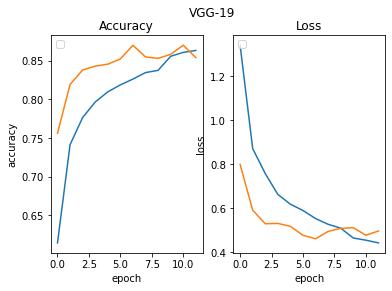

In [20]:
# Training the final model VGG no augmentations
#Experimenting with Inception
datagen_train, datagen_valid = set_up_augmentation(
    rotation_range=25,
    guassian_blur=0.25,
    zoom = 0.2,
    horizontal_flip=0.5
)

model, train_generator, valid_generator\
    , STEP_SIZE_TRAIN, STEP_SIZE_VALID, es = \
    initialize_model(applications.VGG19, datagen_train, datagen_valid, 15, data=train)

history = model.fit_generator(generator=train_generator,\
                    validation_data = valid_generator, \
                    steps_per_epoch=STEP_SIZE_TRAIN, \
                    validation_steps=STEP_SIZE_VALID, \
                    epochs=50, \
                    verbose=1, \
                    callbacks=[es])

printHistory(history, 'output/chart_final_newaug.jpg')
model.save("models/chart_cls.h5")

In [21]:
# get predict prob and label 
ypred = model.predict_generator(valid_generator)

y_true = valid_generator.classes
ypred = np.argmax(ypred, axis=1)

/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [22]:
print('Classification Report')
print(classification_report(y_true, ypred))

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        54
           1       0.88      0.95      0.92        86
           2       0.75      0.80      0.77        54
           3       0.85      0.85      0.85        53
           4       0.76      0.78      0.77        54
           5       0.73      0.84      0.78        49
           6       0.81      0.67      0.73        45
           7       0.79      0.68      0.73        56
           8       0.99      0.96      0.97       384
           9       0.96      0.75      0.84        59
          10       0.92      0.92      0.92        62
          11       0.70      0.76      0.73        58
          12       0.85      0.95      0.90        85
          13       0.63      0.68      0.65        50
          14       0.88      0.91      0.89        55

    accuracy                           0.87      1204
   macro avg       0.83      0.82      0.82      1204
weig

Confusion Matrix
[[ 48   1   2   0   0   1   0   0   1   1   0   0   0   0   0]
 [  1  82   2   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   2  43   0   0   2   0   0   0   0   0   4   2   1   0]
 [  0   0   0  45   0   0   0   0   0   0   2   2   2   1   1]
 [  0   0   3   0  42   0   0   4   0   0   0   0   1   4   0]
 [  0   0   0   0   0  41   0   1   0   1   0   3   2   1   0]
 [  3   0   0   2   0   3  30   0   0   0   0   6   1   0   0]
 [  0   0   1   1   4   0   1  38   1   0   0   0   0   9   1]
 [  2   2   0   0   2   0   5   0 369   0   1   0   1   0   2]
 [  0   6   3   0   0   1   0   1   0  44   0   1   2   1   0]
 [  0   0   0   2   0   0   0   0   0   0  57   0   0   1   2]
 [  1   0   1   0   0   5   0   1   0   0   0  44   3   2   1]
 [  0   0   2   1   0   0   0   0   0   0   0   1  81   0   0]
 [  0   0   0   0   6   2   1   3   2   0   0   2   0  34   0]
 [  0   0   0   2   1   0   0   0   0   0   2   0   0   0  50]]


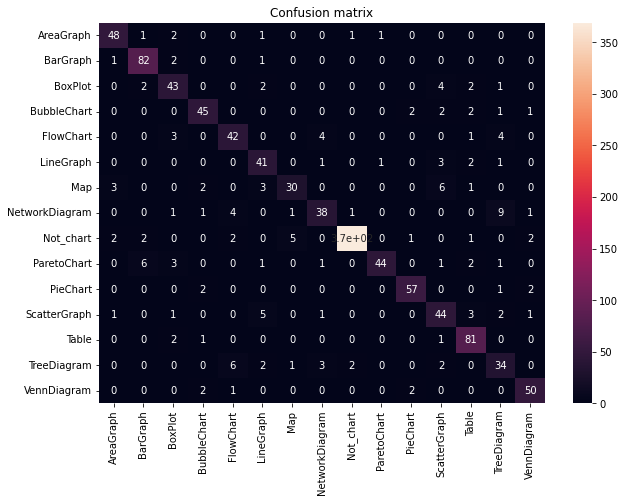

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
cf_matrix = confusion_matrix(y_true, ypred)
print(cf_matrix)

import seaborn as sns

target_names = ['AreaGraph', 'BarGraph', 
        'BoxPlot', 'BubbleChart', 
        'FlowChart', 'LineGraph',
        'Map', 'NetworkDiagram',
        'Not_chart', 'ParetoChart',
        'PieChart', 'ScatterGraph',
        'Table', 'TreeDiagram',
        'VennDiagram']

y_pred = ypred

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = target_names,
                  columns = target_names)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion matrix')


plt.savefig('output/nature_cls_confusion_M')

## Display the visualization of the Confusion Matrix.
plt.show()

In [21]:
# # Now we predict the validation iimages one by one to ensure they match
# from tqdm import tqdm
# tqdm.pandas()

# def predict_img(img):
#   # example of converting an image with the Keras API
#   from tensorflow.keras.preprocessing.image import load_img
#   from tensorflow.keras.preprocessing.image import img_to_array

#   img_path = os.path.join(DIR_, 'Images/Images', img)
#   image = np.expand_dims(img_to_array(load_img(img_path, target_size=(224, 224))) / 255, axis=0)
#   pred = model.predict(image)
  
#   return np.argmax(pred, axis=1)[0]

# test['prediction'] = test.chart.progress_map(lambda x: predict_img(x))
# test

100%|██████████| 1204/1204 [00:48<00:00, 24.82it/s]


,chart,type,code,transparency,prediction
4675,PNXGF_2019_SustainabilityReport_28_Im60_jpg.rf...,Not_chart,8,False,8
5693,GS_2019_SustainabilityReport_43_Im8798_jpg.rf....,Not_chart,8,False,8
1434,75.compliance-reporting-process-flow-chart.png,FlowChart,4,False,4
5441,CAT_2015_SustainabilityReport_51_Im62_jpg.rf.3...,Not_chart,8,False,8
5695,COO_2019_SustainabilityReport_23_Im15357_jpg.r...,Not_chart,8,False,8
...,...,...,...,...,...
285,127.7uh73.png,BarGraph,1,False,1
855,330.boxplot6.jpg,BoxPlot,2,False,2
2916,295.ggplot2-scatter-plot-logo-data-visualizati...,ScatterGraph,11,False,5
1276,180.ceqa_process_chart.gif,FlowChart,4,False,4


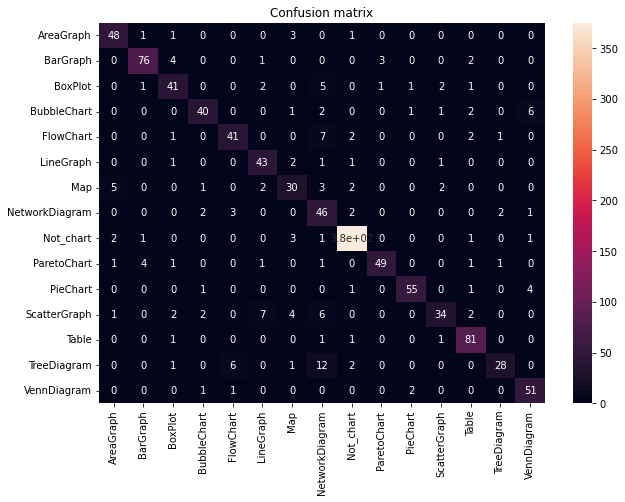

Classification Report
                precision    recall  f1-score   support

     AreaGraph       0.84      0.89      0.86        54
      BarGraph       0.92      0.88      0.90        86
       BoxPlot       0.77      0.76      0.77        54
   BubbleChart       0.85      0.75      0.80        53
     FlowChart       0.80      0.76      0.78        54
     LineGraph       0.77      0.88      0.82        49
           Map       0.68      0.67      0.67        45
NetworkDiagram       0.54      0.82      0.65        56
     Not_chart       0.97      0.98      0.97       384
   ParetoChart       0.92      0.83      0.88        59
      PieChart       0.93      0.89      0.91        62
  ScatterGraph       0.83      0.59      0.69        58
         Table       0.87      0.95      0.91        85
   TreeDiagram       0.88      0.56      0.68        50
   VennDiagram       0.81      0.93      0.86        55

      accuracy                           0.86      1204
     macro avg       0.8

In [22]:
# Confution Matrix and Classification Report
import seaborn as sns

target_names = ['AreaGraph', 'BarGraph', 
        'BoxPlot', 'BubbleChart', 
        'FlowChart', 'LineGraph',
        'Map', 'NetworkDiagram',
        'Not_chart', 'ParetoChart',
        'PieChart', 'ScatterGraph',
        'Table', 'TreeDiagram',
        'VennDiagram']

y_pred = test.prediction
y_true = test.code

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = target_names,
                  columns = target_names)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion matrix')
plt.savefig('output/confusion_matrx_chart.jpg')
plt.show()


print('Classification Report')
print(classification_report(y_true, y_pred, target_names=target_names))

#### Now we attempt to train a classifier to identify inverted images

In [24]:
# Load the data

DIR_inv = 'Data/inverted_cls/'
inverted_folders = os.listdir(DIR_inv)

In [30]:
import shutil

d = []
for c in inverted_folders:
    if c != 'Agg_images':
        classes_path = os.path.join(DIR_inv, c)

        img_files = os.listdir(classes_path)
        
        for img in img_files:
            
            img_src = os.path.join(DIR_inv, c, img)
            img_dest = os.path.join(DIR_inv, 'Agg_images', img)

            shutil.copy(img_src, img_dest)

            d.append(
                {
                    'filename': img,
                    'class': c
                }
            )

inv_train = pd.DataFrame(d)
inv_train.to_csv(os.path.join(DIR_inv, 'train.csv'))

In [26]:
inv_train = pd.read_csv('Data/inverted_cls/train.csv')

inv_train['code'] = inv_train['class'].astype('category').cat.codes
print(len(inv_train.code.unique()), inv_train.shape)
inv_train.head()

2 (10111, 4)


,Unnamed: 0,filename,class,code
0,0,3M_2017_SustainabilityReport_105_Im145.jpg,Clean,0
1,1,3M_2015_SustainabilityReport_119_Im78.jpg,Clean,0
2,2,3M_2017_SustainabilityReport_105_Im150.jpg,Clean,0
3,3,3M_2015_SustainabilityReport_123_Im82.jpg,Clean,0
4,4,3M_2017_SustainabilityReport_105_Im151.jpg,Clean,0


In [27]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(inv_train, test_size=0.2, random_state=420)

In [30]:
def initialize_model_inv(Model_name, datagen_train,datagen_valid, final_classes):
    model = createModel(Model_name, final_classes)

    train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                            directory=os.path.join(DIR_inv,'Agg_images'),
                                            x_col="filename",
                                            y_col="class",
                                            batch_size=32,
                                            seed=42,
                                            color_mode="rgb",
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(224, 224)
                                            , validate_filenames=False
                                            );

    valid_generator=datagen_valid.flow_from_dataframe(dataframe=test,
                                            directory=os.path.join(DIR_inv,'Agg_images'),
                                            x_col="filename",
                                            y_col="class",
                                            batch_size=32,
                                            seed=42,
                                            color_mode="rgb",
                                            shuffle=False,
                                            class_mode="categorical",
                                            target_size=(224, 224)
                                            , validate_filenames=False
                                            );

    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size


    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

    return model, train_generator, valid_generator, STEP_SIZE_TRAIN, STEP_SIZE_VALID, es

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
batch_normalization_844 (Bat (None, 5, 5, 1536)        6144      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 3, 3, 1536)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 3, 3, 1536)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 4096)              5662

/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
252/252 [==============================] - 86s 311ms/step - loss: 0.6554 - accuracy: 0.7554 - val_loss: 0.4846 - val_accuracy: 0.8452
Epoch 2/50
252/252 [==============================] - 76s 301ms/step - loss: 0.3985 - accuracy: 0.8476 - val_loss: 0.4247 - val_accuracy: 0.8636
Epoch 3/50
252/252 [==============================] - 74s 295ms/step - loss: 0.3349 - accuracy: 0.8731 - val_loss: 0.3113 - val_accuracy: 0.8849
Epoch 4/50
252/252 [==============================] - 74s 295ms/step - loss: 0.2733 - accuracy: 0.8917 - val_loss: 0.2812 - val_accuracy: 0.9018
Epoch 5/50
252/252 [==============================] - 75s 298ms/step - loss: 0.2544 - accuracy: 0.8989 - val_loss: 0.2477 - val_accuracy: 0.9117
Epoch 6/50
252/252 [==============================] - 74s 294ms/step - loss: 0.2224 - accuracy: 0.9206 - val_loss: 0.2524 - val_accuracy: 0.9117
Epoch 7/50
252/252 [==============================] - 75s 299ms/step - loss: 0.1807 - accuracy: 0.9320 - val_loss: 0.2647 - val_ac

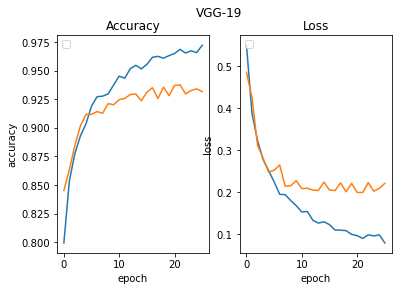

In [37]:
datagen_train, datagen_valid = set_up_augmentation(
    rotation_range=25,
    # guassian_blur=0.25,
    # zoom = 0.2,
    horizontal_flip=0.5
)

model, train_generator, valid_generator\
    , STEP_SIZE_TRAIN, STEP_SIZE_VALID, es = \
    initialize_model_inv(applications.InceptionResNetV2, datagen_train, datagen_valid, 2)

history = model.fit_generator(generator=train_generator,\
                    validation_data = valid_generator, \
                    steps_per_epoch=STEP_SIZE_TRAIN, \
                    validation_steps=STEP_SIZE_VALID, \
                    epochs=50, \
                    verbose=1, \
                    callbacks=[es])

printHistory(history, 'output/inverted_final_newaug.jpg')
model.save("models/inverted_cls.h5")

In [33]:
# get predict prob and label 
ypred = model.predict_generator(valid_generator)

y_true = valid_generator.classes
ypred = np.argmax(ypred, axis=1)

/home/3049637/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[949  80]
 [ 53 941]]


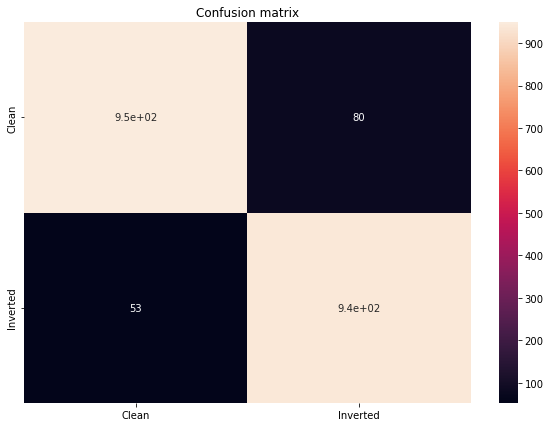

Classification Report
              precision    recall  f1-score   support

       Clean       0.95      0.92      0.93      1029
    Inverted       0.92      0.95      0.93       994

    accuracy                           0.93      2023
   macro avg       0.93      0.93      0.93      2023
weighted avg       0.93      0.93      0.93      2023



In [34]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
cf_matrix = confusion_matrix(y_true, ypred)
print(cf_matrix)

import seaborn as sns

target_names = ['Clean', 'Inverted']

y_pred = ypred

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = target_names,
                  columns = target_names)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion matrix')


plt.savefig('output/nature_cls_confusion_M')

## Display the visualization of the Confusion Matrix.
plt.show()

print('Classification Report')
print(classification_report(y_true, ypred, target_names=target_names))